# AnanseScanpy vignette for multiomics PBMC dataset

PBMC multiomics datasets scanpy objects (anndata) generated from Seurat objects with SeuratDisk

In [1]:
import scanpy as sc
from anansescanpy import *

sc.set_figure_params(figsize=(4, 4))

In [2]:
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.3.0
anansescanpy        0.1.8
asttokens           NA
backcall            0.2.0
cffi                1.15.1
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.3
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
executing           1.2.0
h5py                3.7.0
ipykernel           6.17.1
ipython_genutils    0.2.0
jedi                0.18.1
joblib              1.2.0
jupyter_server      1.23.2
kiwisolver          1.4.4
llvmlite            0.39.1
matplotlib          3.6.2
matplotlib_inline   0.1.6
mpl_toolkits        NA
natsort             8.2.0
numba               0.56.4
numpy               1.23.4
packaging           21.3
pandas              1.5.1
parso               0.8.3
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       NA
platformdirs        2.5.4
prompt_toolkit      3.0.32
psutil              5.9.4
ptyprocess          0.

In [3]:
# Fill in the directories where the h5ad rna and atac objects are located
atac_PBMC = sc.read("atac_PBMC.h5ad")
rna_PBMC= sc.read("rna_PBMC.h5ad")

# Notes: the default assays for atac_PBMC and rna_PBMC are "peaks" and "counts" respectively

# Nessesary pre-processing from converted Seurat object
rna_PBMC.obs['predicted.id'] = rna_PBMC.obs['predicted.id'].str.replace(' ', '-')
atac_PBMC.obs['predicted.id'] = atac_PBMC.obs['predicted.id'].str.replace(' ', '-')

In [4]:
# Run the functions in python:
outputdir="AnanseScanpy_outs/"
contrasts=["B-naive_B-memory","B-memory_B-naive","B-naive_CD14-Mono"
           ,"CD14-Mono_B-naive"]
minimal=25
export_CPM_scANANSE(anndata=rna_PBMC,min_cells=minimal,outputdir=outputdir
                    ,cluster_id="predicted.id")
export_ATAC_scANANSE(anndata=atac_PBMC,min_cells=minimal,outputdir=outputdir
                     ,cluster_id="predicted.id")
config_scANANSE(anndata=rna_PBMC,min_cells=minimal,outputdir=outputdir,
                cluster_id="predicted.id",additional_contrasts=contrasts)
DEGS_scANANSE(anndata=rna_PBMC,min_cells=minimal,outputdir=outputdir,
              cluster_id="predicted.id",additional_contrasts=contrasts)

gather data from CD4-Naive with 1414 cells
gather data from CD4-TCM with 1592 cells
gather data from CD8-Naive with 1496 cells
gather data from CD16-Mono with 527 cells
gather data from NK with 492 cells
gather data from Treg with 160 cells
gather data from CD14-Mono with 3095 cells
gather data from CD8-TCM with 73 cells
gather data from B-intermediate with 351 cells
gather data from cDC2 with 168 cells
gather data from B-memory with 159 cells
gather data from CD4-TEM with 172 cells
gather data from MAIT with 121 cells
gather data from CD8-TEM with 664 cells
gather data from B-naive with 424 cells
gather data from gdT with 164 cells
gather data from pDC with 110 cells
gather data from HSPC with 26 cells
gather data from CD4-Naive with 1414 cells
gather data from CD4-TCM with 1592 cells
gather data from CD8-Naive with 1496 cells
gather data from CD16-Mono with 527 cells
gather data from NK with 492 cells
gather data from Treg with 160 cells
gather data from CD14-Mono with 3095 cells
gat

After running ANANSNAKE you can import back the results to the scanpy object 
and visualize a heatmap of the top factors with seaborn

In [5]:
df=import_scanpy_scANANSE(anndata=rna_PBMC,cluster_id="predicted.id",
                       anansnake_inf_dir="/AnanseScanpy_outs/influence/")

/vol/mbconda/julian/envs/AnanseScanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [6]:
# Generate a UMAP if not performed already during pre-processing
adata=rna_PBMC
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)

/vol/mbconda/julian/envs/AnanseScanpy/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/vol/mbconda/julian/envs/AnanseScanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


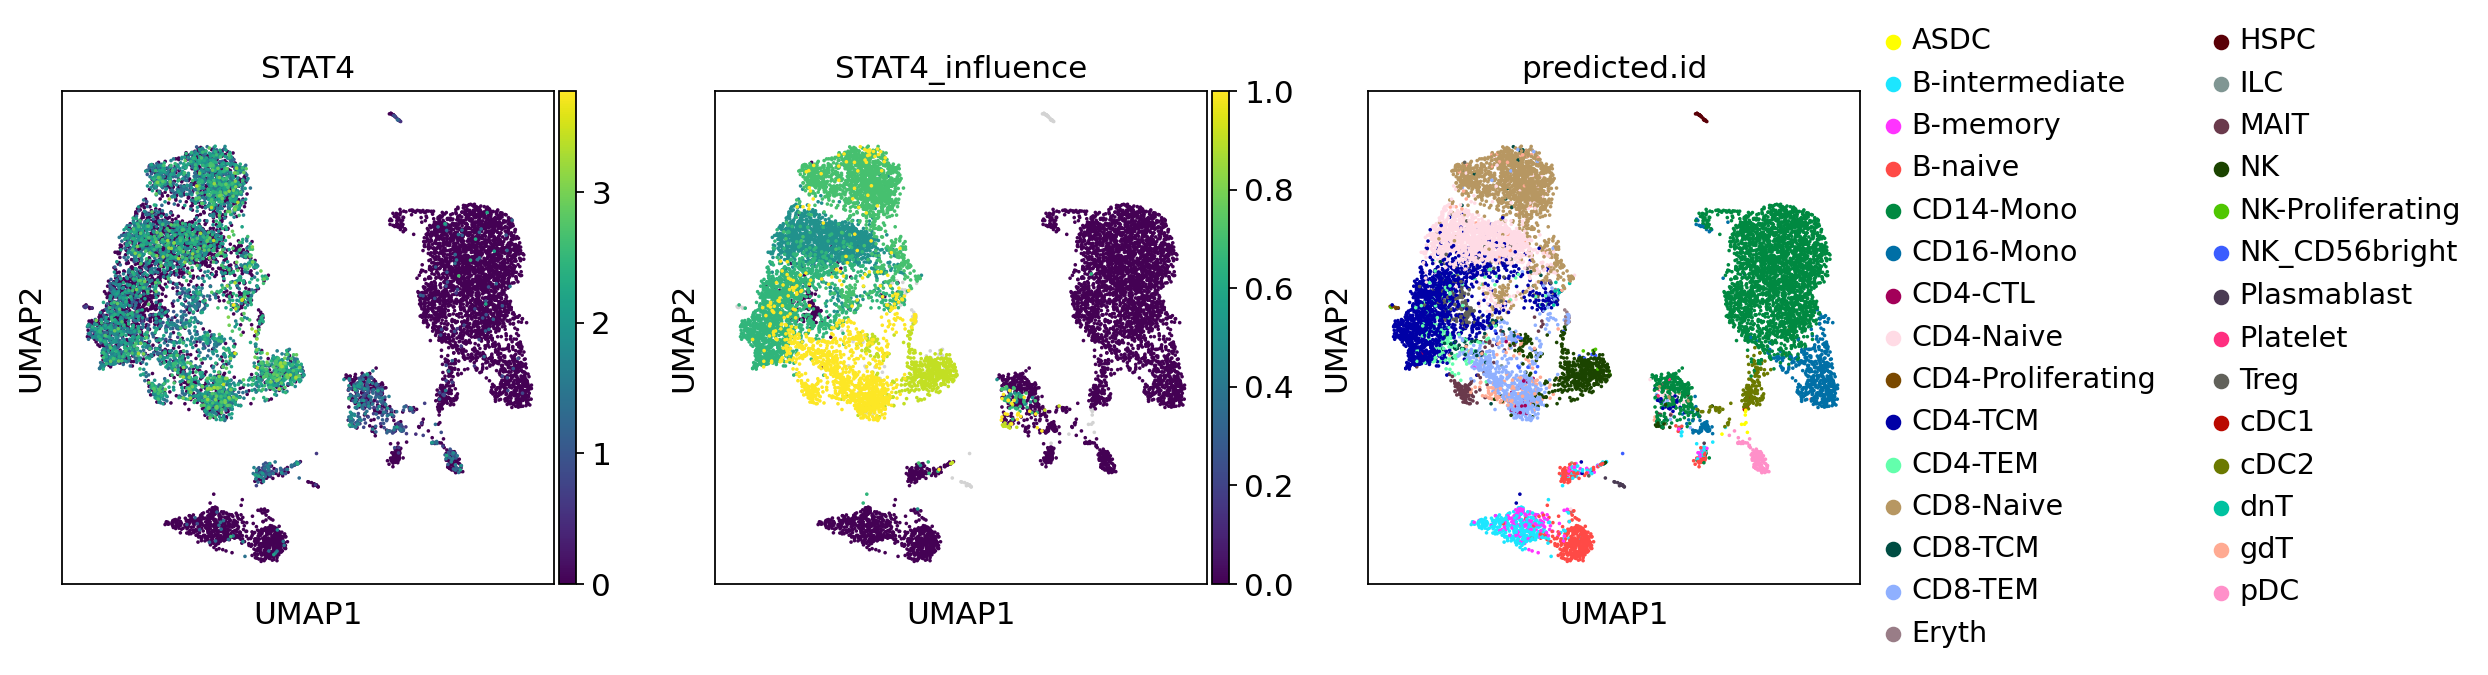

In [7]:
# Show expression and influence values of transcription factors on the UMAP
sc.pl.umap(adata, color=["STAT4","STAT4_influence","predicted.id"], cmap="viridis")

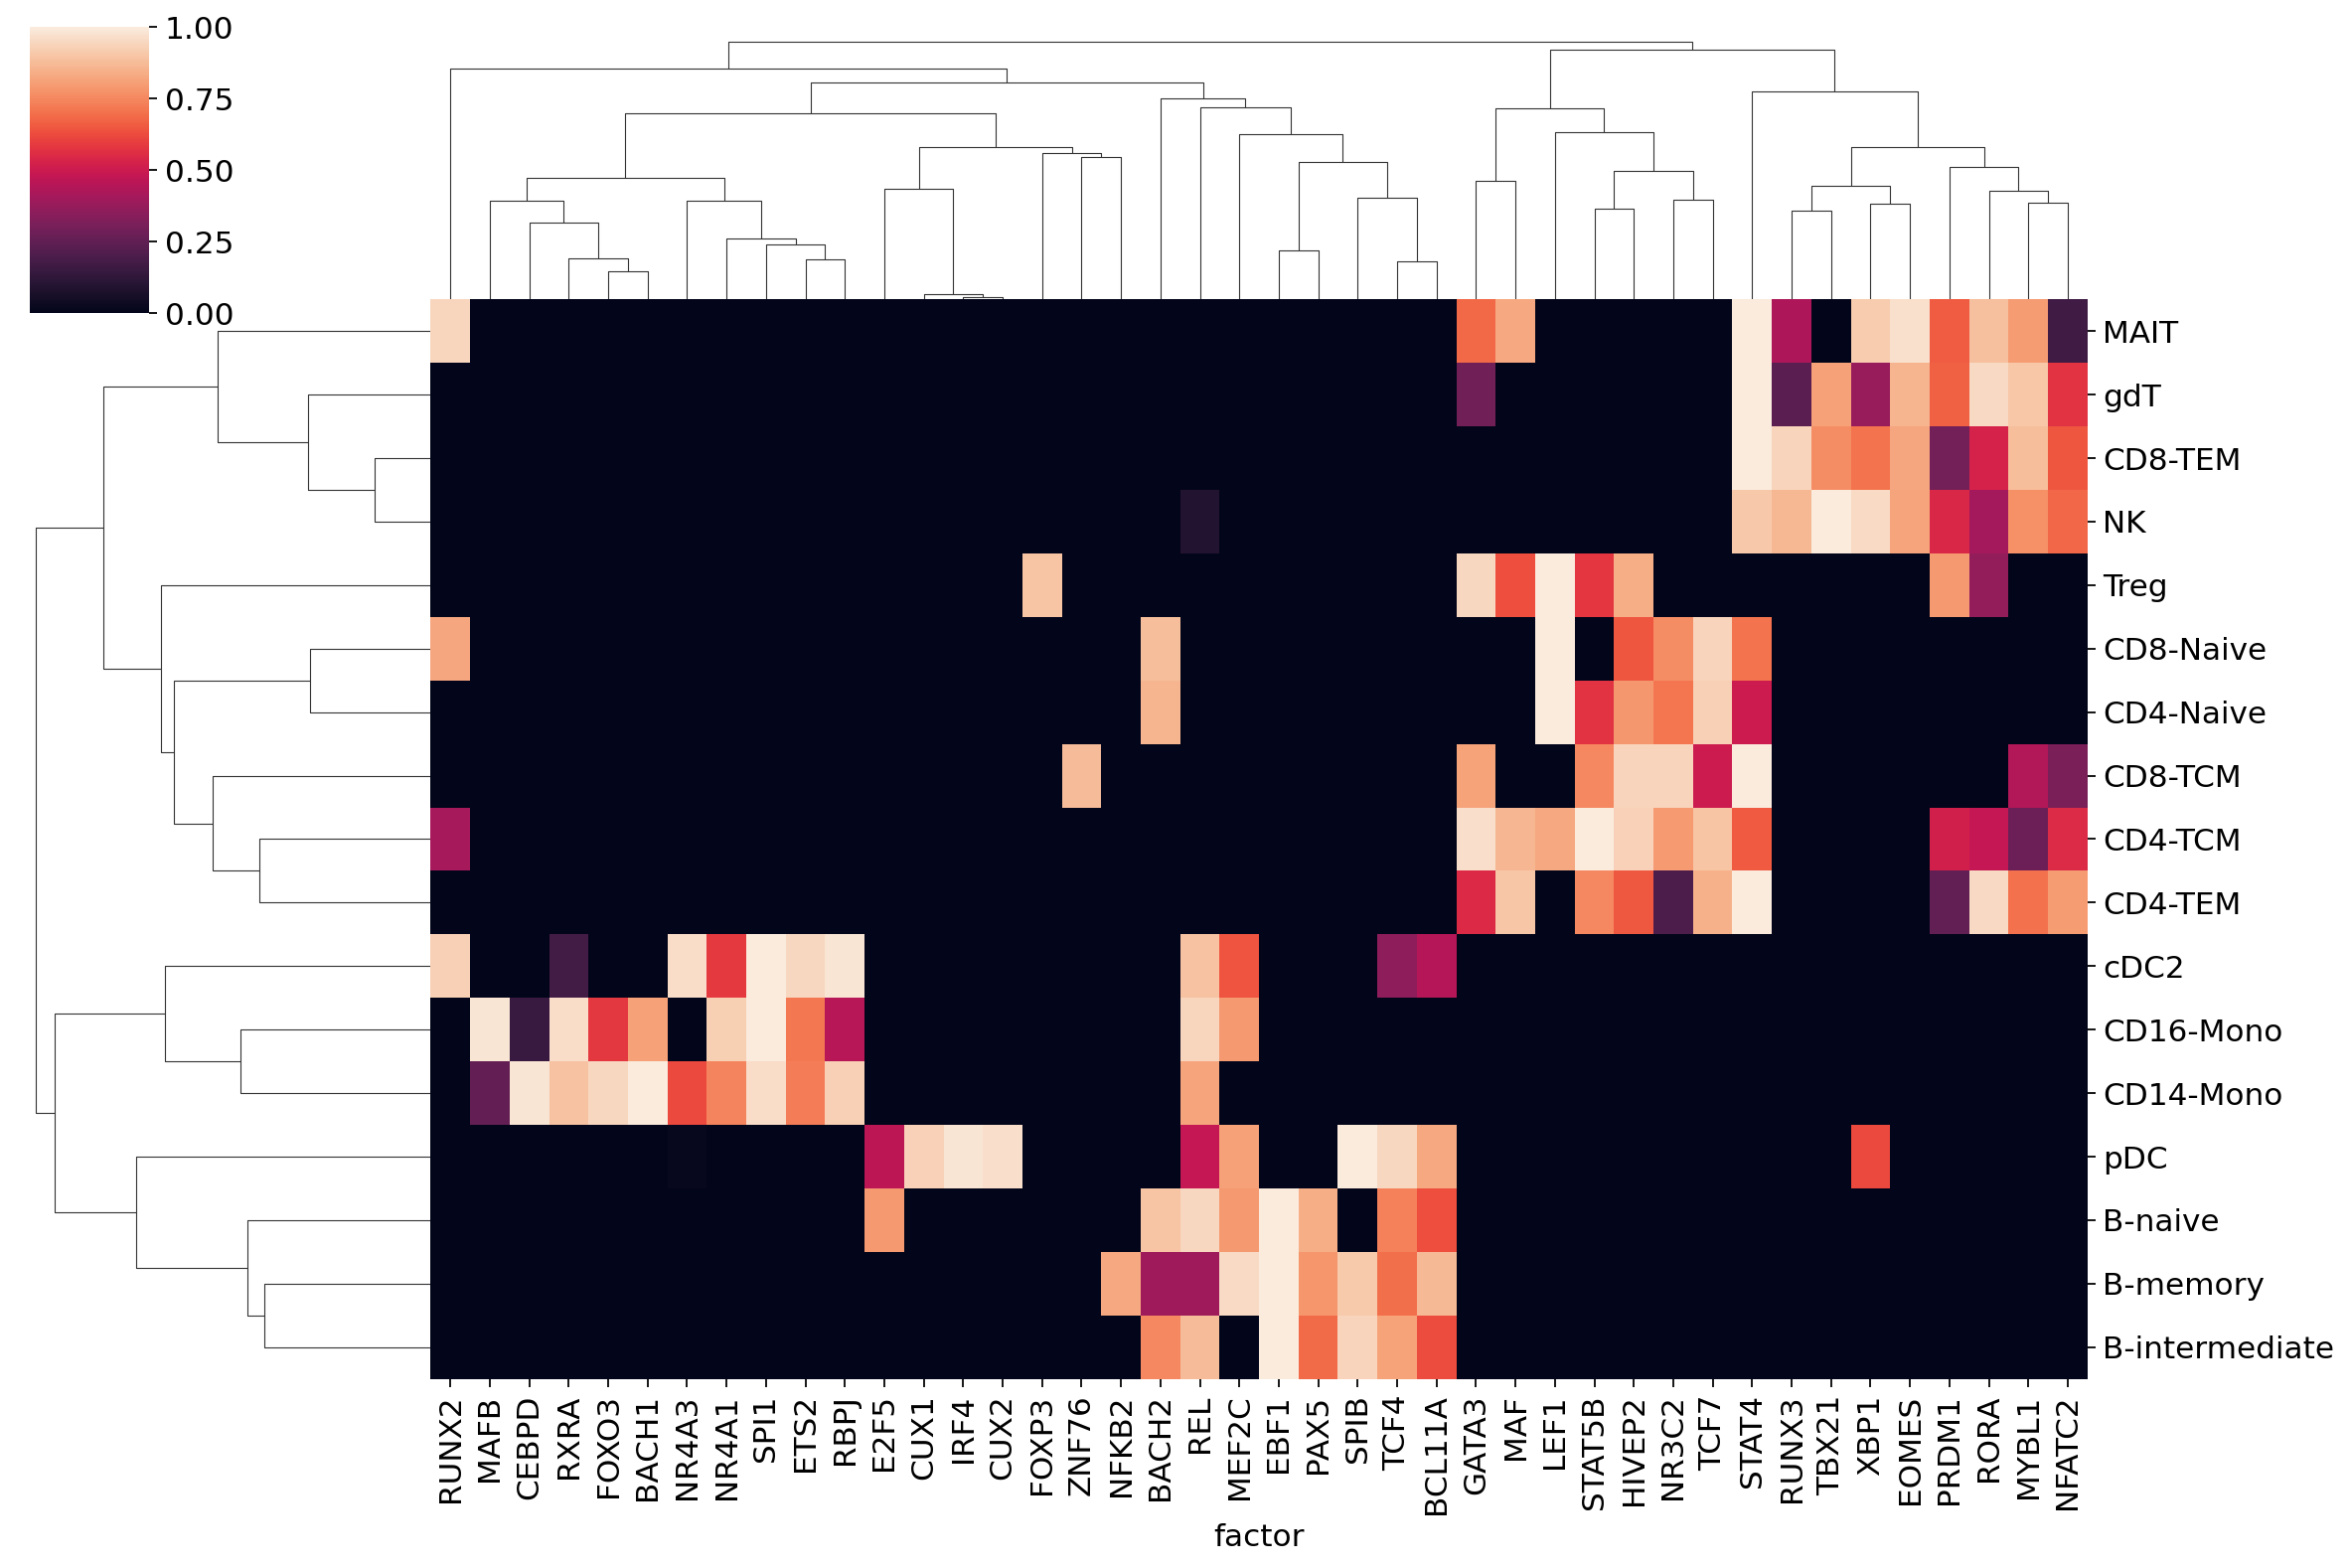

In [8]:
# Make a heatmap of the top 5 transcription factors for each population
import seaborn as sns
top=5

df_t = df.transpose()
factors_topn = []
for i in df_t:
    df_sub=df_t[i]
    test = df_sub.sort_values(ascending=False)
    factors_topn.append(list(test[0:top].index))
    
factors_topn=[j for i in factors_topn for j in i]
factors_topn=set(factors_topn)

selected_df = df[list(factors_topn)]
sns.clustermap(selected_df, annot=False, figsize=(15, 10))